In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time


In [2]:
#download MNIST data
import gzip
import sys
import struct
import urllib.request
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )
     

In [3]:
import numpy as np
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


0


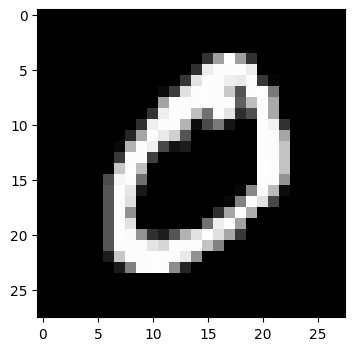

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Index number of an instance (change this to view another instance).
i = 1

data = np.load('mnist.npz')
image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image, cmap='gray')
plt.show()
     

In [5]:
import numpy as np

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))         # Flatten: (N x 28 x 28) -> (N x 784)
    return X

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])   # (60000 x 784)
Ytrain = data['train_y']                    # (60000)
Xtest = image_to_vector(data['test_x'])     # (10000 x 784)
Ytest = data['test_y']                      # (10000)

In [6]:
import TensorFrost as tf
tf.initialize(tf.opengl)

TensorFrost module loaded!


In [7]:
def leaky_relu(X):
	return tf.select(X > 0.0, X, 0.01 * X)

def softmax(X):
    exp = tf.exp(X)
    norm = tf.sum(exp, axis = 1)
    return exp / tf.reshape(norm, [exp.shape[0], 1])

def leaky_relu(X):
	return tf.select(X > 0.0, X, 0.01 * X)

def forward(W1, W2, b1, b2, X):
    L1 = leaky_relu(tf.matmul(X, W1) + b1)
    L2 = tf.matmul(L1, W2) + b2
    L3 = softmax(L2)
    return L1, L2, L3

def loss(Y, Yhat): #cross entropy loss
    Y *= 1.0 #tensor view bug
    return tf.sum(tf.sum( - Y * tf.log(Yhat + 1e-6) - (1.0 - Y) * tf.log(1.0 - Yhat + 1e-6))) / tf.float(Y.shape[1] * Y.shape[0])

def backward(W1, W2, b1, b2, L1, L2, L3, X, Y):
    #derivative of cross entropy loss with respect to L2
    dL2 = (L3 - Y) / tf.float(L3.shape[1] * L3.shape[0])
    dW2 = tf.matmul(tf.transpose(L1), dL2)
    db2 = tf.sum(dL2, axis = 0)
    dL1 = tf.matmul(dL2, tf.transpose(W2)) * tf.select(L1 > 0.0, 1.0, 0.01)
    dW1 = tf.matmul(tf.transpose(X), dL1)
    db1 = tf.sum(dL1, axis = 0)
    return dW1, dW2, db1, db2

def update(W1, W2, b1, b2, dW1, dW2, db1, db2, lr):
    W1 -= lr * dW1
    W2 -= lr * dW2
    b1 -= lr * db1
    b2 -= lr * db2
    return W1, W2, b1, b2

def step():
    #input weights and biases
    W1 = tf.input([-1, -1], tf.float32)
    In, Hidden = W1.shape
    W2 = tf.input([Hidden, -1], tf.float32)
    Out = W2.shape[1]
    b1 = tf.input([Hidden], tf.float32)
    b2 = tf.input([Out], tf.float32)

    #input data
    X = tf.input([-1, In], tf.float32)
    Y = tf.input([-1, Out], tf.float32)
    
    info = tf.input([3], tf.float32)
    offset = tf.int(info[0])
    batch_size = tf.int(info[1])
    learning_rate = info[2]

    #TODO: implement slicing instead of this crap
    i, j = tf.indices([batch_size, In])
    Xbatch = X[i + offset, j]
    i, j = tf.indices([batch_size, Out])
    Ybatch = Y[i + offset, j]

    L1, L2, Yhat = forward(W1, W2, b1, b2, Xbatch)
    L = loss(Ybatch, Yhat)
    dW1, dW2, db1, db2 = backward(W1, W2, b1, b2, L1, L2, Yhat, Xbatch, Ybatch)
    W1, W2, b1, b2 = update(W1, W2, b1, b2, dW1, dW2, db1, db2, learning_rate)

    return [L, W1, W2, b1, b2]

train_step = tf.compile(step)

step:
  Kernel count: 16
  Intermediate buffers: 12
  Host readbacks: 1
  Host writes: 0
  Lines of generated code: 471
  IR Compile time: 9.411400 ms
  Compiler time: 4551.218750 ms



In [8]:
def forward_step():
    #input weights and biases
    W1 = tf.input([-1, -1], tf.float32)
    In, Hidden = W1.shape
    W2 = tf.input([Hidden, -1], tf.float32)
    Out = W2.shape[1]
    b1 = tf.input([Hidden], tf.float32)
    b2 = tf.input([Out], tf.float32)

    #input data
    X = tf.input([-1, In], tf.float32)

    L1, L2, Yhat = forward(W1, W2, b1, b2, X)
    return [Yhat]

fwd_step = tf.compile(forward_step)

forward_step:
  Kernel count: 4
  Intermediate buffers: 3
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 428
  IR Compile time: 2.009200 ms
  Compiler time: 3673.402100 ms



In [9]:
Xsamples = Xtrain
Ysamples = np.zeros((Xsamples.shape[0], 10))
Ysamples[np.arange(Xsamples.shape[0]), Ytrain] = 1.0

print (Xsamples.shape)
print (Ysamples.shape)

hidden_size = 128

#W = np.random.randn(28 * 28, 10).astype(np.float32) # (784 x 10)
#b = np.random.randn(10).astype(np.float32) # (10)

W1 = np.random.randn(28 * 28, hidden_size).astype(np.float32) # (784 x 10)
W2 = np.random.randn(hidden_size, 10).astype(np.float32) # (10)
b1 = np.random.randn(hidden_size).astype(np.float32) # (10)
b2 = np.random.randn(10).astype(np.float32) # (10)

#normalize weights
W1 /= np.sqrt(28 * 28)
W2 /= np.sqrt(hidden_size)

(60000, 784)
(60000, 10)


In [10]:
W1tf = tf.tensor(W1)
W2tf = tf.tensor(W2)
b1tf = tf.tensor(b1)
b2tf = tf.tensor(b2)
Xtf = tf.tensor(Xsamples)
Ytf = tf.tensor(Ysamples)

In [11]:
batch_size = 4096
epochs = 1000
iterations = Xsamples.shape[0] // batch_size
learning_rate = 10.0

loss_curve = []

for i in range(epochs):
    avg_loss_tf = 0.0
    for j in range(iterations):
        offset = j * batch_size
        info = np.array([offset, batch_size, learning_rate]).astype(np.float32)
        info_tf = tf.tensor(info)
        L, W1tf, W2tf, b1tf, b2tf = train_step(W1tf, W2tf, b1tf, b2tf, Xtf, Ytf, info_tf)
        loss = L.numpy
        avg_loss_tf += loss
        #print("Epoch: ", i, " Iteration: ", j, " Tf Loss: ", loss)
    loss_curve.append(avg_loss_tf / iterations)
    print("Epoch: ", i, " Tf Loss: ", avg_loss_tf / iterations)

Epoch:  0  Tf Loss:  [0.28738648]
Epoch:  1  Tf Loss:  [0.15844175]
Epoch:  2  Tf Loss:  [0.09662377]
Epoch:  3  Tf Loss:  [0.07024918]
Epoch:  4  Tf Loss:  [0.05791665]
Epoch:  5  Tf Loss:  [0.04893017]
Epoch:  6  Tf Loss:  [0.04612776]
Epoch:  7  Tf Loss:  [0.0444037]
Epoch:  8  Tf Loss:  [0.0414114]
Epoch:  9  Tf Loss:  [0.03824426]
Epoch:  10  Tf Loss:  [0.03888647]
Epoch:  11  Tf Loss:  [0.03682095]
Epoch:  12  Tf Loss:  [0.03353772]
Epoch:  13  Tf Loss:  [0.03234471]
Epoch:  14  Tf Loss:  [0.03126499]
Epoch:  15  Tf Loss:  [0.03023145]
Epoch:  16  Tf Loss:  [0.02926666]
Epoch:  17  Tf Loss:  [0.02835648]
Epoch:  18  Tf Loss:  [0.02749547]
Epoch:  19  Tf Loss:  [0.02670259]
Epoch:  20  Tf Loss:  [0.02596933]
Epoch:  21  Tf Loss:  [0.02528372]
Epoch:  22  Tf Loss:  [0.0246271]
Epoch:  23  Tf Loss:  [0.02401298]
Epoch:  24  Tf Loss:  [0.02343877]
Epoch:  25  Tf Loss:  [0.02289945]
Epoch:  26  Tf Loss:  [0.02237783]
Epoch:  27  Tf Loss:  [0.0218869]
Epoch:  28  Tf Loss:  [0.02141808]

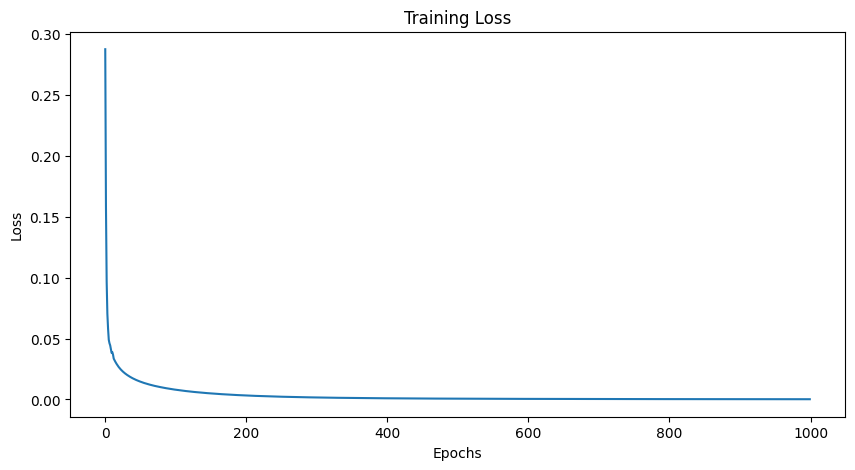

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_curve)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Tf Accuracy:  97.72 %
Prediction:  7  Label:  7
Prediction:  2  Label:  2
Prediction:  1  Label:  1
Prediction:  0  Label:  0
Prediction:  4  Label:  4
Prediction:  1  Label:  1
Prediction:  4  Label:  4
Prediction:  9  Label:  9
Prediction:  9  Label:  5
Prediction:  9  Label:  9


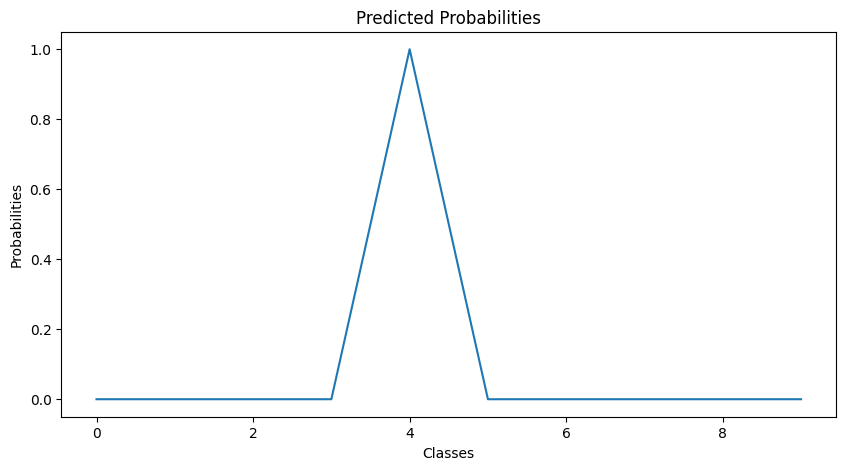

In [13]:
# Test the model
#Wtf = tf.tensor(W)
#btf = tf.tensor(b)
correct_tf = 0
np.set_printoptions(precision=5, suppress=True)

Yhat, = fwd_step(W1tf, W2tf, b1tf, b2tf, tf.tensor(Xtest))
Yhatnp = Yhat.numpy
Predict = np.argmax(Yhatnp, axis = 1)
correct_tf = np.sum(Predict == Ytest)

print("Tf Accuracy: ", correct_tf * 100.0 / len(Ytest) , "%")

#print some predictions
for i in range(10):
    print("Prediction: ", Predict[i], " Label: ", Ytest[i])

#plot the probabilities Yhatnp
plt.figure(figsize=(10, 5))
plt.plot(Yhatnp[6])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predicted Probabilities')
plt.show()


In [14]:
import time

ImageSize = 1024

tf.show_window(ImageSize, ImageSize, "Digit Recognizer")

prev_time = time.time()

#Canvas = np.zeros((28, 28), np.float32)
#take the first image from the test set
Canvas = Xtest[9].reshape(28, 28)

while not tf.window_should_close():
    cur_time = time.time() 
    time_tf = tf.tensor(np.array([cur_time], np.float32))
    mx, my = tf.get_mouse_position()
    cur_time = time.time()
    delta_time = cur_time - prev_time
    tf.imgui_text("Prediction time: %.3f ms" % (delta_time * 1000.0))


    if tf.is_mouse_button_pressed(tf.MOUSE_BUTTON_0):
        #draw on the canvas
        x = mx * 28 / ImageSize
        y = my * 28 / ImageSize
        #add a gaussian blob
        for i in range(28):
            for j in range(28):
                dx = j - x
                dy = i - y
                Canvas[i, j] += 0.5 * np.exp(-2.0 * (dx * dx + dy * dy))

    Canvas = np.clip(Canvas, 0.0, 1.0)
    canvas_flat = Canvas.reshape(1, -1)
    canvas_tf = tf.tensor(canvas_flat)

    #predict
    Yhat, = fwd_step(W1tf, W2tf, b1tf, b2tf, canvas_tf)

    Yhatnp = Yhat.numpy
    
    if(tf.imgui_button("Clear")):
        Canvas = np.zeros((28, 28), np.float32)
    tf.imgui_text("Prediction: %d" % np.argmax(Yhatnp))
    tf.imgui_text("Distribution: ")
    for i in range(10):
        tf.imgui_text("Class %d: %.3f" % (i, Yhatnp[0, i]))
    
    #draw the canvas
    frame_tf = np.zeros((28, 28, 3), np.float32)
    frame_tf[:, :, 0] = Canvas
    frame_tf[:, :, 1] = Canvas
    frame_tf[:, :, 2] = Canvas

    frame_tf = np.flipud(frame_tf)

    frame_tf = tf.tensor(frame_tf)
    tf.render_frame(frame_tf)

    prev_time = cur_time


tf.hide_window()